In [1]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob


from tqdm import tqdm

from utils import visualize, plot_data
from scipy.io import loadmat


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
%matplotlib inline

In [3]:
path = '/mnt/home/hbaiaa/USERDIR/data/FDST'
train_images = path + '/train/img'
test_images = path + '/test/img'
#anno = path + '/annotation'
#images = path + '/rf_image_vehicle'
#density_maps = path + '/rf_GT_vehicle'

LOG_PARA = 1000

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Resize(360,640,interpolation=2),
            #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        ],
        #additional_targets={'image': 'image','image1': 'image'}
        #keypoint_params = A.KeypointParams(format='xy')
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            #A.Resize(360,640),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3,p=0.2),
            A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ],
        additional_targets={'image': 'image'}
    )

def get_valid_trainsforms():
    return A.Compose(
        [
            #A.Resize(360,640,interpolation=2),
            A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
    )

# def get_valid_image_only_transforms():
#     return A.Compose(
#         [
#             A.Resize(360,640),
#         ],
#         additional_targets={'image': 'image'}
#     )

#mean = torch.tensor([0.4939, 0.4794, 0.4583])
#std = torch.tensor([0.2177, 0.2134, 0.2144])
mean = torch.tensor([0.38868062, 0.38568735, 0.39457315])
std = torch.tensor([0.221865, 0.23096273, 0.2210397])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [5]:
class Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4):
        '''
            path: root path 
            image_fnames: path of images
            dmap_folder: density map folder, eg: /dmap
            gt_folder: gt folder, currently set to visdrone xml format, modify _get_gt_data() if needed
            transforms: iteratable, can be tuple / list ... etc
            mosaic: mix up image and density map to form a new image, set to false by default
            downsample: resize dmap
        '''
        super().__init__()
        self.path = path
        self.image_fnames = image_fnames
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.downsample = downsample
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        h,w = image.shape[0]//self.downsample, image.shape[1]//self.downsample
        image = cv2.resize(image,(w, h))
        density_map = cv2.resize(density_map,(w//(self.downsample*2),h//(self.downsample*2)))#,interpolation=cv2.INTER_NEAREST)
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + '.npy'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        d_map = np.load(dmap_fname,allow_pickle=True)
        d_map = d_map.squeeze()
        #if image.shape[0] < 384:
        #    padding = (384 - image.shape[0]) // 2
        #    image = cv2.copyMakeBorder(image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        #    d_map = cv2.copyMakeBorder(d_map, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        if len(boxes) == 0:
            return result_boxes
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + '.mat'
        test_data = loadmat(anno_path)
        points = test_data['annotation'].astype(int)
        return fn, points

In [6]:
# ADD LOG_PARA to density map

class Crop_Dataset(Counting_Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4,crop_size=512,method='train'):
        super().__init__(path,image_fnames,dmap_folder,gt_folder,transforms,mosaic,downsample)
        self.crop_size = crop_size
        if method not in ['train','valid']:
            raise Exception('Not Implement')
        self.method = method
    
    def __getitem__(self,idx):
        fn = self.image_fnames[idx]
        
        image,density_map,gt_points = self._load_image_and_density_map(idx)
        density_map = density_map.squeeze()
        h,w = image.shape[0], image.shape[1]
        #image = cv2.resize(image,(w, h))
        
        if self.method == 'train':
            #h,w = image.shape[:2]
            i,j = self._random_crop(h,w,self.crop_size,self.crop_size)
            image = image[i:i+self.crop_size,j:j+self.crop_size]
            density_map = density_map[i:i+self.crop_size,j:j+self.crop_size]
            #print(density_map.shape)
            #gt_points = gt_points - [j,i]
            #mask = (gt_points[:,0] >=0 ) * (gt_points[:,0] <= self.crop_size) * (gt_points[:,1]>=0) * (gt_points[:,1]<=self.crop_size)
            #gt_points = gt_points[mask]
            density_map = cv2.resize(density_map,(self.crop_size//self.downsample,self.crop_size//self.downsample))
            
        else:
            density_map = cv2.resize(density_map,(w//self.downsample,h//self.downsample))#,interpolation=cv2.INTER_NEAREST)
            #density_map = density_map[1:-1,:]
        
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        return image, density_map*LOG_PARA, fn, gt_points
    
    def _random_crop(self, im_h, im_w, crop_h, crop_w):
        res_h = im_h - crop_h
        res_w = im_w - crop_w
        i = random.randint(0, res_h)
        j = random.randint(0, res_w)
        return i, j

In [10]:
train_fp = glob(train_images + '/*.jpg')
test_fp = glob(test_images + '/*.jpg')

In [11]:
train_fp[:10]

['/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/037_061.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/031_094.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/042_023.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/078_127.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/036_069.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/076_018.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/087_088.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/017_059.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/008_007.jpg',
 '/mnt/home/hbaiaa/USERDIR/data/FDST/train/img/068_039.jpg']

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
img = cv2.imread(train_fp[2])

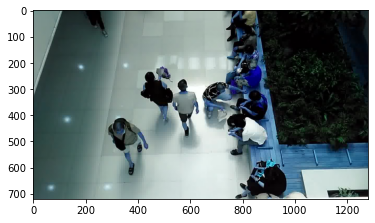

In [26]:
plt.imshow(img)
plt.show()

In [27]:
dmap = np.load('/mnt/home/hbaiaa/USERDIR/data/FDST/train/ground_truth/042_023.npy')

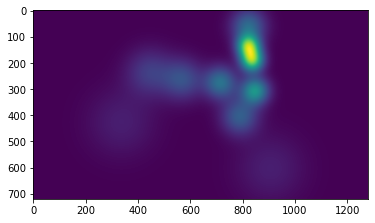

In [28]:
plt.imshow(dmap)
plt.show()

In [29]:
anno = loadmat('/mnt/home/hbaiaa/USERDIR/data/FDST/train/annotation/037_061.mat')

In [31]:
anno['annotation']

array([[354, 309],
       [344, 344],
       [487, 324],
       [486, 346],
       [452, 367],
       [445, 395],
       [449, 445],
       [459, 467],
       [437, 477],
       [448, 509],
       [449, 528],
       [452, 540],
       [545, 535]], dtype=int32)

In [48]:
hws = []
for fn in tqdm(train_fp):
    img = cv2.imread(fn)
    h,w,_ = img.shape
    hws.append((h,w))

100%|██████████| 9003/9003 [03:58<00:00, 37.69it/s]


In [49]:
hw_counts = np.unique(hws, return_counts=True, axis=0)
hw_counts

(array([[ 720, 1280],
        [1080, 1920]]),
 array([ 900, 8103]))

In [50]:
hws2 = []
for fn in tqdm(test_fp):
    img = cv2.imread(fn)
    h,w,_ = img.shape
    hws2.append((h,w))

100%|██████████| 6000/6000 [04:54<00:00, 20.38it/s]


In [52]:
hw_counts2 = np.unique(hws2, return_counts=True, axis=0)
hw_counts2

(array([[ 720, 1280],
        [1080, 1920]]),
 array([ 900, 5100]))

In [16]:
global_mean = AverageMeter()
for fn in tqdm(train_fp):
    img = cv2.imread(fn)
    global_mean.update(img.mean(axis=(0,1)), img.shape[0]*img.shape[1])
print(global_mean.avg)

  2%|▏         | 161/9003 [00:53<49:19,  2.99it/s]  


KeyboardInterrupt: 

In [ ]:
g_mean = global_mean.avg / 255.0
g_mean

In [ ]:
global_std2 = AverageMeter()
for fn in tqdm(fp):
    img = (cv2.imread(fn) - global_mean.avg) / 255.0
    global_std2.update(np.mean(np.square(img), axis=(0,1)), img.shape[0]*img.shape[1])
print(np.sqrt(global_std2.avg))

In [ ]:
new_fp = []
for fn in tqdm(fp):
    img = cv2.imread(fn)
    h, w, _ = img.shape
    if h == 512 and w == 688:
        new_fp.append(fn)

In [ ]:
split = int(len(fp) * 0.8)
fp[0:split][:10]

In [ ]:
hs = []
ws = []
for fn in tqdm(fp):
    img = cv2.imread(fn)
    h, w, _ = img.shape
    hs.append(h)
    ws.append(w)

In [ ]:
hs = np.array(hs)
ws = np.array(ws)

In [ ]:
h_counts = np.unique(hs, return_counts=True)
h_counts

In [ ]:
w_counts = np.unique(ws, return_counts=True)
w_counts

In [ ]:
hws = list(zip(hs, ws))

In [ ]:
hws[0]

In [ ]:
hw_counts = np.unique(hws, return_counts=True, axis=0)
hw_counts

In [ ]:
vfp = glob(path + '/rf_image_vehicle' + '/*.jpg')

In [ ]:
hws = []
for fn in tqdm(vfp):
    img = cv2.imread(fn)
    h, w, _ = img.shape
    hws.append((h,w))

In [ ]:
hw_counts = np.unique(hws, return_counts=True, axis=0)
hw_counts

In [ ]:
import numpy as np
hws = np.array([[352, 480],
        [368, 672],
        [384, 688],
        [512, 688],
        [528, 944],
        [528, 960],
        [736, 992]])
cts = np.array([1, 662, 928, 1921, 353, 415, 659])

In [ ]:
hws[:,0] *= cts
hws[:,1] *= cts
hws

In [ ]:
hws.sum(axis=0)/4919

In [32]:
train_dataset = Crop_Dataset(path=path,
                             image_fnames=train_fp,dmap_folder='/train/ground_truth',
                             #gt_folder='/annotation',
                             transforms=[get_train_transforms(),get_train_image_only_transforms()],
                             downsample=1,
                             crop_size=512
                                )

valid_dataset = Crop_Dataset(path=path,
                             image_fnames=test_fp,dmap_folder='/test/ground_truth',
                             #gt_folder='/annotation',
                             transforms=[get_valid_trainsforms()],
                             method='valid',
                             downsample=1
                             #crop_size=448
                                )

In [33]:
img, dmap, fn, pt = train_dataset[0]

In [42]:
class TrainGlobalConfig:
    num_workers = 32
    batch_size = 16
    n_epochs = 10 
    lr = 0.0002

    folder = 'test_delete'
    downsample = 1

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-4,
        #total_steps = len(train_dataset) // 4 * n_epochs, # gradient accumulation
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.2,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [35]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    @torch.cuda.amp.autocast()
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    @torch.cuda.amp.autocast()
    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [36]:
class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,3,1,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,3,1,start_with_relu=True,grow_first=True)

        #self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,2,2,start_with_relu=True,grow_first=True)

        self.block12=Block(728,512,3,1,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(512,512,3,1,1)
        self.bn3 = nn.BatchNorm2d(512)

        #do relu here
        self.conv4 = SeparableConv2d(512,512,3,1,1)
        self.bn4 = nn.BatchNorm2d(512)

        #self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.block4(x)
        # x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        # x = self.block8(x)
        # x = self.block9(x)
        # x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = self.relu(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x
    
    @torch.cuda.amp.autocast()
    def forward(self, input):
        x = self.features(input)
        # x = self.logits(x)
        return x

In [37]:
class SANet(nn.Module):
    def __init__(self):
        super(SANet, self).__init__()
        self.FME=Xception()
        self.DME = nn.Sequential(nn.Conv2d(512, 64, 9, 1, padding=4),
                                 nn.ReLU(inplace=True),
                               nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                 nn.ReLU(inplace=True),
                               nn.Conv2d(64, 32, 7, 1, padding=3),
                                 nn.ReLU(inplace=True),
                               nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                                 nn.ReLU(inplace=True),
                               nn.Conv2d(32, 16, 5, 1, padding=2),
                                 nn.ReLU(inplace=True),
                               nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                                 nn.ReLU(inplace=True),
                               nn.Conv2d(16, 16, 3, 1, padding=1),
                                 nn.ReLU(inplace=True),
                               nn.Conv2d(16, 16, 5, 1, padding=2),
                                 nn.ReLU(inplace=True),
                               # nn.Conv2d(16, 16, 3, 1, padding=2, dilation=2),
                               nn.Conv2d(16, 1, 1, 1, padding=0))    
    
    @torch.cuda.amp.autocast()
    def forward(self, x):
        # x = self.layer1(x)
        # x = self.layer2(x)
        x = self.FME(x)
        x = self.DME(x)
        return x

In [38]:
def MSELoss_MCNN(preds,targs):
    return nn.MSELoss()(preds,targs)

def MAELoss_MCNN(preds,targs,upsample):
    return nn.L1Loss()((preds/LOG_PARA).sum(dim=[-1,-2])*upsample*upsample, (targs/LOG_PARA).sum(dim=[-1,-2])*upsample*upsample)

In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [43]:
import warnings
warnings.filterwarnings("ignore")

#opt_level ='O1' # apex

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'/mnt/home/zpengac/USERDIR/count/drone_benchmark/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        
        #self.model, self.optimizer = amp.initialize(self.model,self.optimizer,opt_level=opt_level) # apex
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = MSELoss_MCNN
        self.metric = MAELoss_MCNN
        self.log(f'Fitter prepared. Device is {self.device}')
        
        # self.iters_to_accumulate = 4 # gradient accumulation

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, mae_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mse_loss: {summary_loss.avg:.8f}, time: {(time.time() - t):.5f}')
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.8f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mae_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, mse_loss: {summary_loss.avg:.8f}, time: {(time.time() - t):.5f}')
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.8f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'mse_loss: {summary_loss.avg:.8f}, ' + \
                        f'mae_loss: {mae_loss.avg:.8f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = images.shape[0]
                images = images.cuda().float()
                density_maps = density_maps.cuda().float()
                

                #preds = self.model(images)
                with torch.cuda.amp.autocast(): #native fp16
                    preds = self.model(images)
                    loss = self.criterion(preds,density_maps)
                    metric_loss = self.metric(preds,density_maps,self.config.downsample)
                mae_loss.update(metric_loss.detach().item(),batch_size)
                summary_loss.update(loss.detach().item(), batch_size)
                
            if step == 20:
                break

        return summary_loss, mae_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'mse_loss: {summary_loss.avg:.8f}, ' + \
                        f'mae_loss: {mae_loss.avg:.8f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = images.cuda().float()
            batch_size = images.shape[0]
            density_maps = density_maps.cuda().float()
            
            
            self.optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(): #native fp16
                preds = self.model(images)
                loss = self.criterion(preds,density_maps)
                metric_loss = self.metric(preds.detach(),density_maps.detach(),self.config.downsample)
            self.scaler.scale(loss).backward()
            
            # loss = loss / self.iters_to_accumulate # gradient accumulation
            
#             with amp.scale_loss(loss,self.optimizer) as scaled_loss: # apex
#                 scaled_loss.backward()
            #loss.backward()

            
            mae_loss.update(metric_loss.detach().item(),batch_size)
            summary_loss.update(loss.detach().item(), batch_size)
            
            #self.optimizer.step()
            self.scaler.step(self.optimizer) # native fp16
            
            if self.config.step_scheduler:
                self.scheduler.step()
            
            self.scaler.update() #native fp16
                
                
#             if (step+1) % self.iters_to_accumulate == 0: # gradient accumulation

#                 self.optimizer.step()
#                 self.optimizer.zero_grad()

#                 if self.config.step_scheduler:
#                     self.scheduler.step()
                    
            if step == 20:
                break

        return summary_loss, mae_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
            #'amp': amp.state_dict() # apex
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [44]:
def collate_fn(batch):
    imgs, dmaps, fns, gt_points = zip(*batch)
    imgs = torch.stack(imgs)
    dmaps = torch.stack(dmaps).unsqueeze(1)
    return imgs,dmaps,fns,gt_points

def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )

    val_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=1, #TrainGlobalConfig.batch_size,
        num_workers=1, #TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=True,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

In [45]:
net = SANet().cuda()

In [46]:
net = nn.DataParallel(net)

In [47]:
run_training()

Fitter prepared. Device is cuda:0

2021-08-31T05:59:19.915465
LR: 4.000000000000002e-06
[RESULT]: Train. Epoch: 0, mse_loss: 0.00212738, time: 142.34772ime: 97.87998
[RESULT]: Train. Epoch: 0, mae_loss: 3.10280209, time: 142.35410
[RESULT]: Val. Epoch: 0, mse_loss: 0.00320516, time: 21.76269, time: 21.20679
[RESULT]: Val. Epoch: 0, mae_loss: 14.01316443, time: 21.76941

2021-08-31T06:02:05.289893
LR: 4.082806638472738e-06
[RESULT]: Train. Epoch: 1, mse_loss: 0.00216193, time: 180.72141ime: 124.53996
[RESULT]: Train. Epoch: 1, mae_loss: 2.79852313, time: 180.72949
[RESULT]: Val. Epoch: 1, mse_loss: 0.00319355, time: 3.259844, time: 2.76438
[RESULT]: Val. Epoch: 1, mae_loss: 12.78818866, time: 3.26528

2021-08-31T06:05:10.237084
LR: 4.33094084808364e-06


KeyboardInterrupt: 

In [ ]:
torch.cuda.device_count()

In [ ]:
val_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=1,
        num_workers=1,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=True,
        collate_fn=collate_fn,
)

In [ ]:
test_net = SANet().cuda()
test_net = nn.DataParallel(test_net)

In [ ]:
checkpoint = torch.load(f'/mnt/home/zpengac/USERDIR/count/drone_benchmark/DENet-drone_vehicle-8.22-384/best-checkpoint-119epoch.bin')
test_net.load_state_dict(checkpoint['model_state_dict'])
test_net.eval()

In [ ]:
imgs, dmaps, fns, points = next(iter(val_loader))

In [ ]:
with torch.no_grad():
    preds = test_net(imgs.cuda())/1000

In [ ]:
ps = preds.sum(dim=[-1,-2])

In [ ]:
preds.shape

In [ ]:
ds = dmaps.sum(dim=[-1,-2])/1000

In [ ]:
ps

In [ ]:
ds

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as pnsr

In [ ]:
%%time

pre_count = []
gt_count = []
gt_points = []
avg_ssim = AverageMeter()
avg_pnsr = AverageMeter()
for imgs, dmaps, fns, points in tqdm(val_loader):
    with torch.no_grad():
        imgs = imgs.cuda().float()
        preds = test_net(imgs) / LOG_PARA
    dmaps = dmaps / LOG_PARA
    
    for pred, dmap in zip(preds, dmaps):
        pred_array = pred.detach().cpu().numpy().squeeze()
        dmap_array = dmap.detach().cpu().numpy().squeeze()
        avg_ssim.update(ssim(dmap_array, pred_array, data_range=dmap_array.max()-dmap_array.min()))
        avg_pnsr.update(pnsr(dmap_array, pred_array, data_range=dmap_array.max()-dmap_array.min()))
    
    pre_count.extend(preds.sum(dim=[-1,-2]).detach().cpu().numpy())
    
    gt_count.extend(dmaps.sum(dim=[-1,-2]).detach().cpu().numpy())
    
    #gt_p = []
    #for p in points:
    #    gt_p.append(len(p))
    #gt_points.extend(gt_p)

In [ ]:
mae = mean_absolute_error(pre_count,gt_count)
mse = mean_squared_error(pre_count,gt_count)
nae = mae * len(pre_count) / np.sum(gt_count)

In [ ]:
def count_parameters_in_MB(model):
    return np.sum(np.prod(v.size()) for name, v in model.named_parameters() if "auxiliary" not in name) / 1e6

print(f'#Paras: {count_parameters_in_MB(test_net)}')
print(f'MAE: {mae}, MSE: {mse}, NAE: {nae}')
print(f'SSIM: {avg_ssim.avg}, PNSR: {avg_pnsr.avg}')